In [1]:
%pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pycountry

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Read libraries

# Data wrangling
import pandas as pd
import numpy as np
import re
import pycountry
from shapely import wkt
import fiona

# Visualization 
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import geopandas as gpd

# Machine learning 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

1. Read in the HFI data

In [4]:
df_2022 = pd.read_csv('/Users/albertcortbanke/Downloads/thesis_missing_data_2023/hfi/hfi_cc_2022.csv')

2. Read in the GeoJSON data

In [5]:
countries_gpd = gpd.read_file('/Users/albertcortbanke/Downloads/thesis_missing_data_2023/country_geometry_json/world-administrative-boundaries.shp')

What can the Human Freedom Score measure, and more importantly, what is it unable to measure?
What attributes are the most important to explore missingness within? (I.e what attributes correlate highly, and would be pointless to measure within)

Spatial, and temporal missingness. How do we address this with spatial models and temporal accountance?


## Merging of geometries and HFI data frame

3. Create a mapping function to convert country names to their corresponding ISO 3166-1 alpha-3 country codes:

In [6]:
def get_country_code(country_name):
    # Handle exceptions directly
    exception_mapping = {
        'Democratic Republic of the Congo': 'COD',
        'The Bahamas': 'BHS',
        'Ivory Coast': 'CIV',
        'Iran': 'IRN',
        'Laos': 'LAO',
        'Russia': 'RUS'
    }
    
    if country_name in exception_mapping:
        return exception_mapping[country_name]
    
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except Exception:
        return None


In [7]:
country_name_mapping = {
    'Bahamas, The': 'The Bahamas',
    'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
    'Congo, Rep.': 'Republic of the Congo',
    "Cote d'Ivoire": 'Ivory Coast',
    'Egypt, Arab Rep.': 'Egypt',
    'Gambia, The': 'Gambia',
    'Hong Kong SAR, China': 'Hong Kong',
    'Iran, Islamic Rep.': 'Iran',
    'Korea, Rep.': 'South Korea',
    'Lao PDR': 'Laos',
    'Venezuela, RB': 'Venezuela',
    'Yemen, Rep.': 'Yemen'
}

In [8]:
df_2022['countries'] = df_2022['countries'].replace(country_name_mapping)

df_2022['country_code'] = df_2022['countries'].apply(get_country_code)

In [9]:
countries_gpd = countries_gpd.rename(columns={"iso3": "country_code"})

In [10]:
# Select only the 'country_code' and 'geometry' columns from the GeoPandas DataFrame
countries_gpd_filtered = countries_gpd[['country_code', 'geometry']]

# Merge the DataFrames on the 'country_code' column
merged_gdf = df_2022.merge(countries_gpd_filtered, on='country_code', how='left')

# Convert the merged DataFrame to a GeoDataFrame, using the 'geometry' column as the geometry
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')


In [11]:
merged_gdf.geometry.isnull().value_counts()

False    3486
Name: geometry, dtype: int64

## Feature selection (mulitcollinarity & VIF)

<AxesSubplot:>

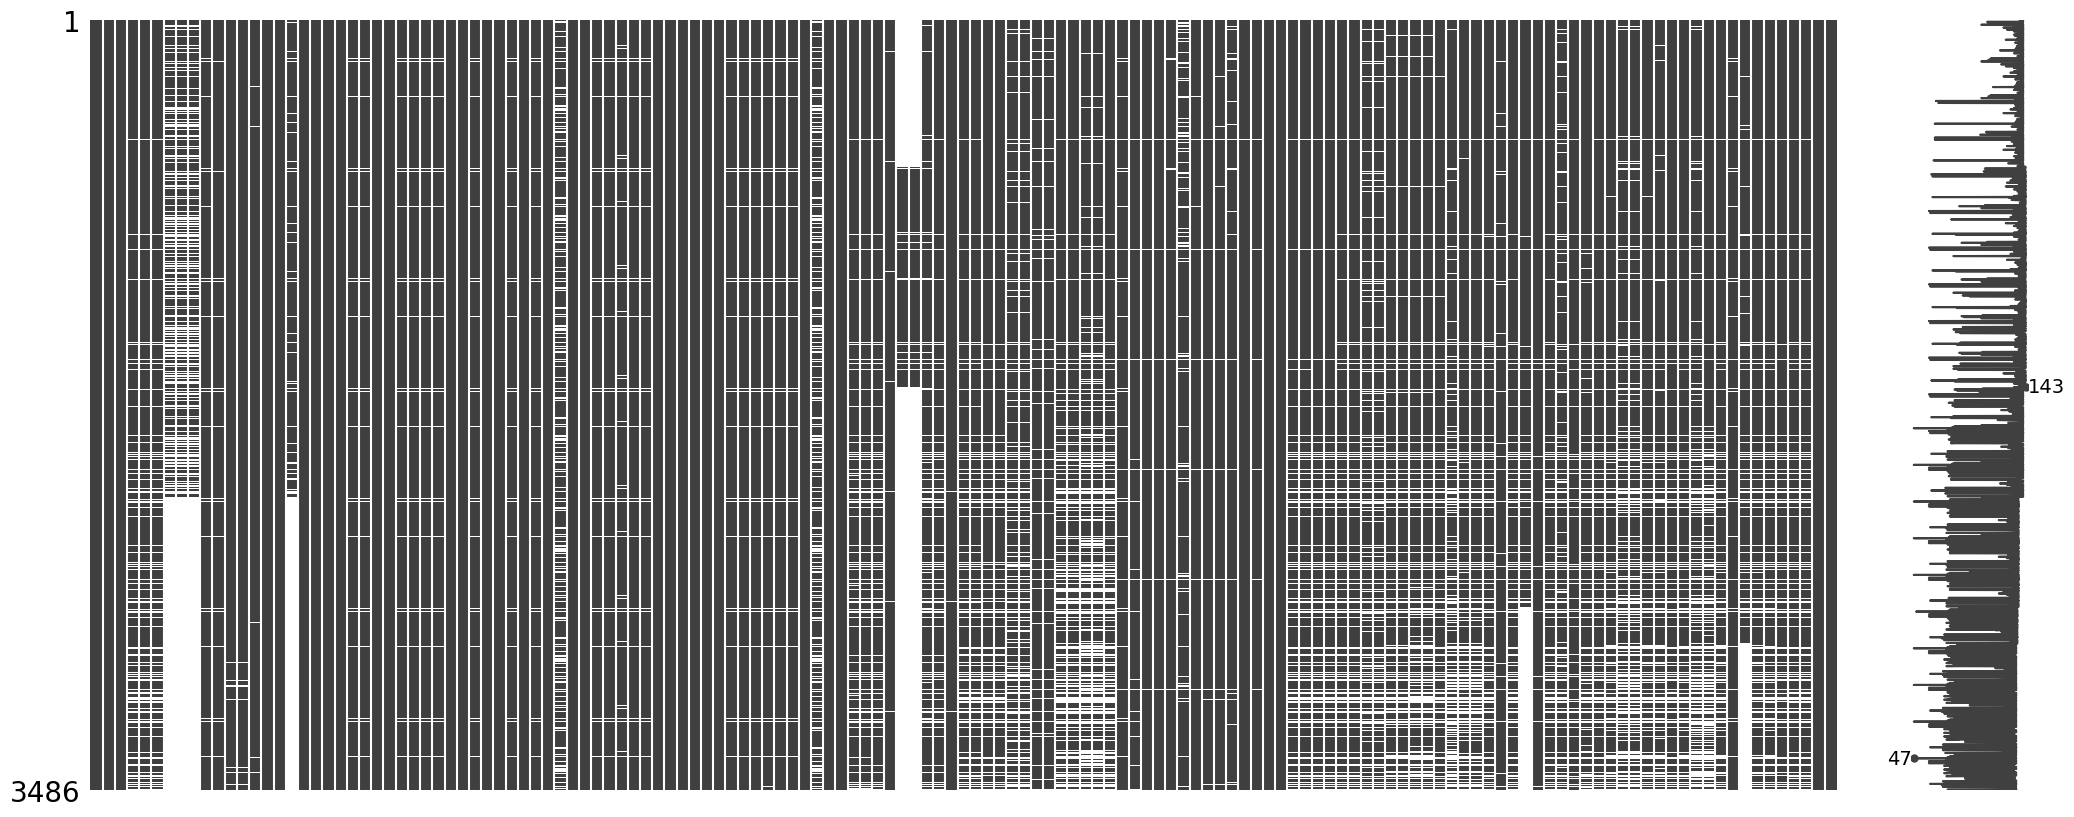

In [12]:
msno.matrix(merged_gdf)

In [13]:
df_copy = merged_gdf.isna().sum()

df_copy = pd.DataFrame(df_copy, columns=['na_count'])

In [14]:
df_copy.sort_values(by='na_count', ascending=False).head(60)

,na_count
pf_identity_inheritance_widows,2563
pf_identity_inheritance_daughters,2563
pf_rol_procedural,2083
pf_rol_civil,2083
pf_rol_criminal,2083
pf_ss_disappearances_organized,1502
ef_trade_movement_visit,1005
pf_expression_bti,991
pf_assembly_freedom_bti,991
ef_regulation_business_licensing,938


In [15]:
# Create a subset with all attributes except for the outcome-variables
df_attributes = merged_gdf.drop(columns=['ef_score','hf_score','pf_score'])

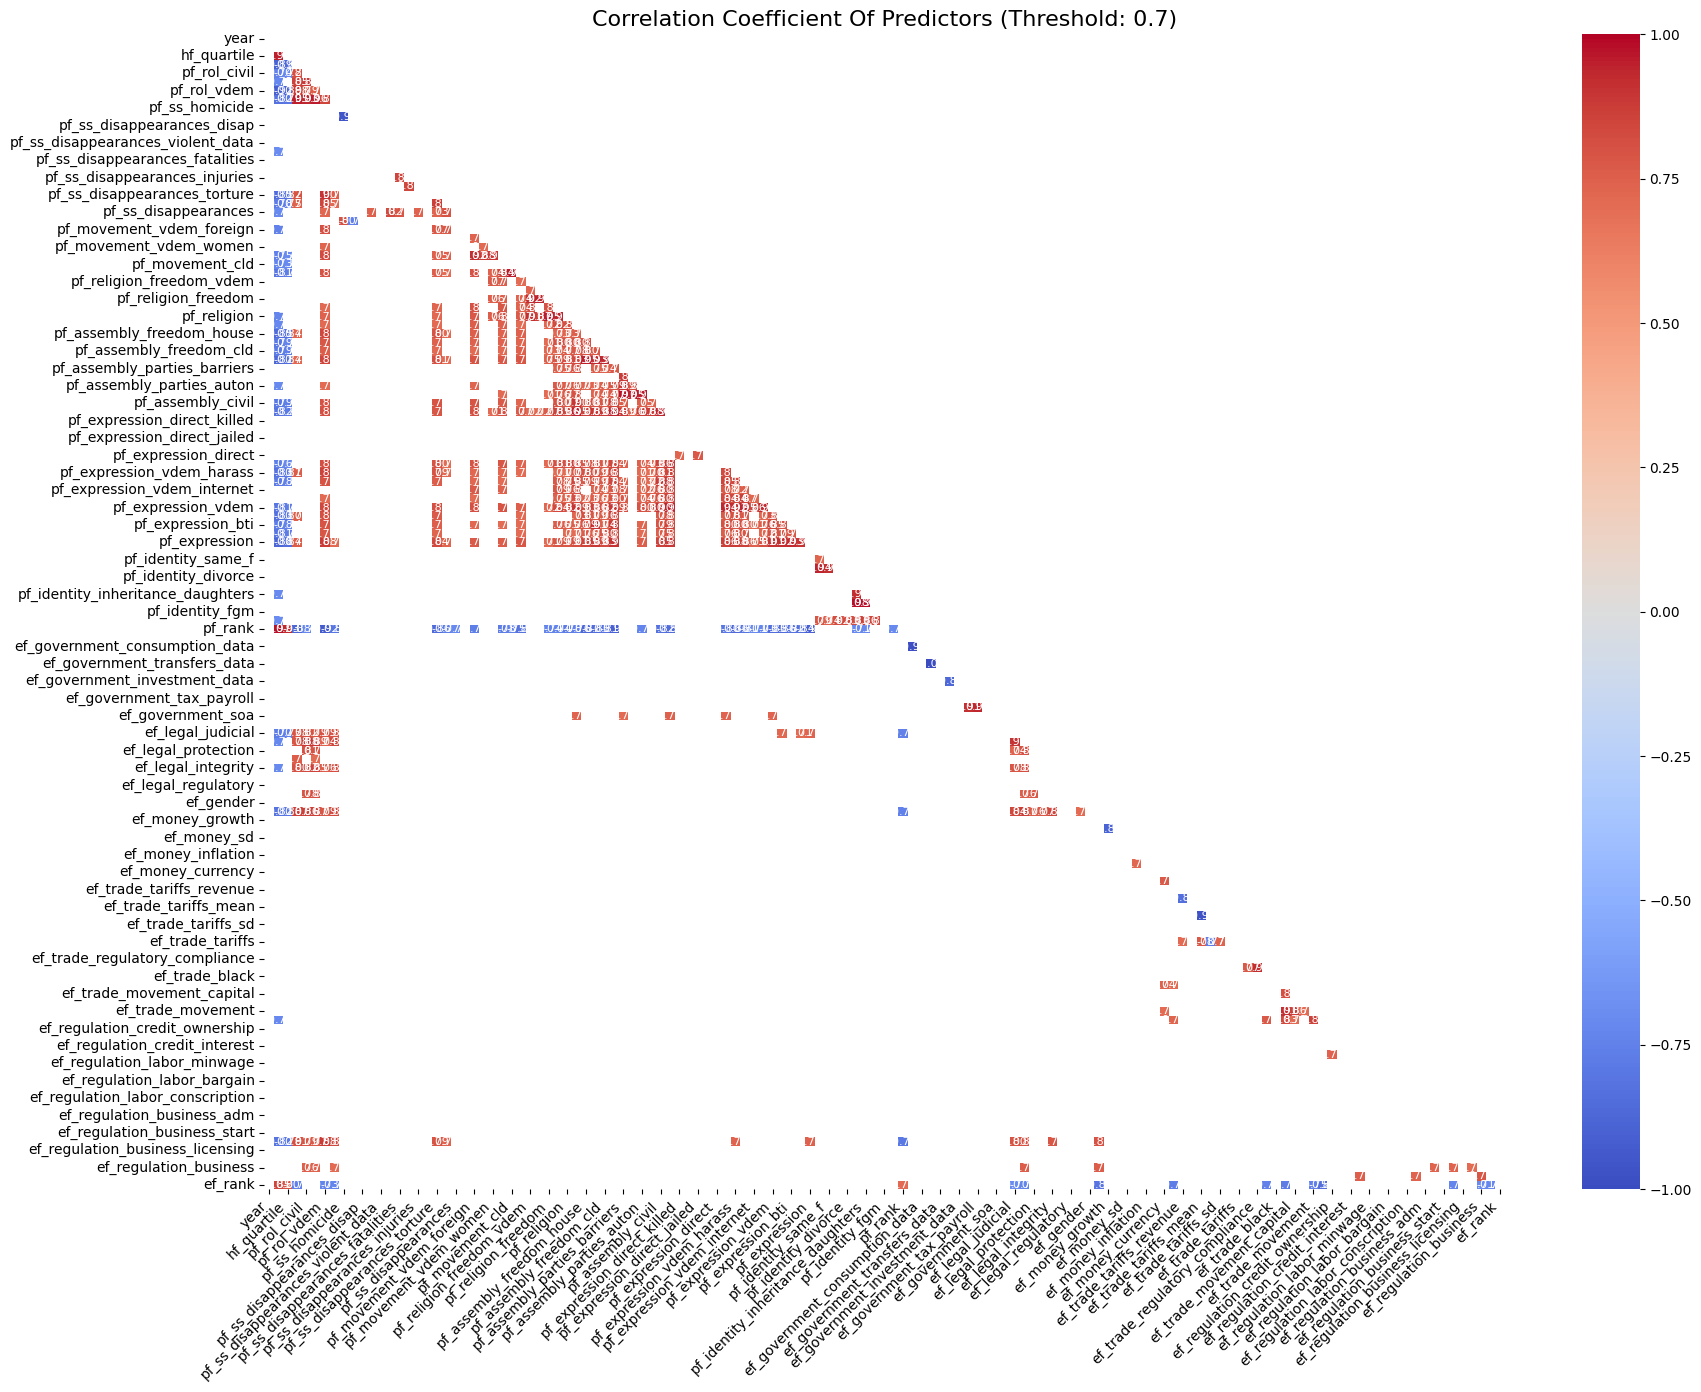

In [16]:
# Heatmap visualizations

# set correlation threshold
corr_threshold = 0.7

# generate correlation matrix
corr_matrix = df_attributes.corr()

# filter to show only highly correlated attributes
high_corr_matrix = corr_matrix[(corr_matrix >= corr_threshold) | (corr_matrix <= -corr_threshold)]

# Generate a mask to only show the bottom triangle
mask = np.triu(np.ones_like(high_corr_matrix, dtype=bool))

# set figure size
plt.figure(figsize=(20, 15))

# generate heatmap
sns.heatmap(high_corr_matrix, annot=True, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})

# rotate x-axis tick labels
plt.xticks(rotation=45, fontsize=10, ha='right')  # Adjust horizontal alignment with `ha` parameter
plt.yticks(fontsize=10)

plt.title(f'Correlation Coefficient Of Predictors (Threshold: {corr_threshold})', fontsize=16)
plt.show()


In [17]:
# Get correlation matrix
corr_matrix = df_attributes.corr()

# Extract features with high correlations
high_correlation_features = set()
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if col != row and abs(corr_matrix.loc[col, row]) > 0.85:
            high_correlation_features.add(col)
            high_correlation_features.add(row)

# Convert the set to a list
high_correlation_features = list(high_correlation_features)

# Print the list of features
print("Features with high correlations:")
for feature in high_correlation_features:
    print(feature)

Features with high correlations:
pf_religion_freedom
ef_trade
pf_identity_same_f
pf_assembly_freedom_house
pf_expression_bti
pf_ss_homicide_data
pf_assembly_parties
pf_rol_procedural
ef_trade_movement
pf_religion_suppression
pf_expression_vdem_gov
pf_rol_vdem
pf_rol
pf_rank
pf_assembly_entry
pf_assembly_freedom_cld
ef_government_transfers
ef_government_investment
pf_assembly_parties_barriers
pf_identity_inheritance_widows
ef_legal_judicial
ef_government_tax_payroll
pf_movement_cld
pf_rol_civil
ef_legal_courts
ef_money_growth
ef_trade_regulatory
pf_identity_same
ef_trade_movement_open
ef_trade_regulatory_compliance
ef_legal_integrity
hf_quartile
pf_expression_vdem
pf_religion_freedom_vdem
ef_legal
pf_identity_same_m
pf_expression_vdem_cultural
ef_money_growth_data
pf_rol_criminal
pf_expression_vdem_harass
pf_expression_vdem_internet
pf_movement_vdem
ef_government_investment_data
pf_identity_inheritance
pf_assembly
pf_religion
pf_movement_vdem_women
pf_assembly_freedom_bti
pf_ss_homicide

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def find_high_vif_features(df, considered_features, vif_threshold=10):
    X = df[considered_features].copy()
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.dropna(inplace=True)

    # Add a constant for the VIF calculation
    X['intercept'] = 1

    # Calculate VIF values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Add features with infinite VIF values to high_vif_features list
    inf_vif_features = vif[vif['VIF'] == float('inf')]['Variable'].tolist()
    high_vif_features = inf_vif_features.copy()

    # Remove features with infinite VIF values from VIF DataFrame
    if inf_vif_features:
        print(f"Removing features with infinite VIF values: {', '.join(inf_vif_features)}")
        vif = vif[vif['VIF'] != float('inf')]
        considered_features = list(set(considered_features) - set(inf_vif_features))

    # Iteratively remove features with VIF values above the threshold
    while (vif['VIF'] > vif_threshold).any():
        max_vif_feature = vif.loc[vif['VIF'].idxmax()]['Variable']
        high_vif_features.append(max_vif_feature)
        print(f"Removing {max_vif_feature} with VIF = {vif.loc[vif['VIF'].idxmax()]['VIF']}")
        vif = vif[vif['Variable'] != max_vif_feature]
        considered_features.remove(max_vif_feature)

    return high_vif_features

# Set a VIF threshold
vif_threshold = 10

# Features to consider removing
considered_features = high_correlation_features

# Find features with high VIF
high_vif_features = find_high_vif_features(df_attributes, considered_features, vif_threshold)

Removing features with infinite VIF values: pf_religion_freedom, pf_identity_same_f, pf_assembly_freedom_house, pf_assembly_parties, pf_rol_procedural, pf_religion_suppression, pf_expression_vdem_gov, pf_rol, pf_assembly_entry, pf_assembly_freedom_cld, pf_assembly_parties_barriers, pf_identity_inheritance_widows, ef_government_tax_payroll, pf_movement_cld, pf_rol_civil, pf_identity_same, pf_expression_vdem, pf_religion_freedom_vdem, pf_identity_same_m, pf_expression_vdem_cultural, pf_rol_criminal, pf_expression_vdem_harass, pf_expression_vdem_internet, pf_movement_vdem, pf_identity_inheritance, pf_assembly, pf_religion, pf_movement_vdem_women, pf_assembly_freedom_bti, pf_assembly_parties_auton, pf_identity_inheritance_daughters, pf_religion_freedom_cld, ef_government_tax, pf_assembly_parties_bans, pf_movement_vdem_men, ef_trade_tariffs_mean, ef_trade_tariffs_mean_data, ef_government_tax_income, pf_movement_vdem_foreign, pf_assembly_civil, pf_movement, pf_assembly_freedom, pf_expression

In [19]:
high_vif_features

['pf_religion_freedom',
 'pf_identity_same_f',
 'pf_assembly_freedom_house',
 'pf_assembly_parties',
 'pf_rol_procedural',
 'pf_religion_suppression',
 'pf_expression_vdem_gov',
 'pf_rol',
 'pf_assembly_entry',
 'pf_assembly_freedom_cld',
 'pf_assembly_parties_barriers',
 'pf_identity_inheritance_widows',
 'ef_government_tax_payroll',
 'pf_movement_cld',
 'pf_rol_civil',
 'pf_identity_same',
 'pf_expression_vdem',
 'pf_religion_freedom_vdem',
 'pf_identity_same_m',
 'pf_expression_vdem_cultural',
 'pf_rol_criminal',
 'pf_expression_vdem_harass',
 'pf_expression_vdem_internet',
 'pf_movement_vdem',
 'pf_identity_inheritance',
 'pf_assembly',
 'pf_religion',
 'pf_movement_vdem_women',
 'pf_assembly_freedom_bti',
 'pf_assembly_parties_auton',
 'pf_identity_inheritance_daughters',
 'pf_religion_freedom_cld',
 'ef_government_tax',
 'pf_assembly_parties_bans',
 'pf_movement_vdem_men',
 'ef_trade_tariffs_mean',
 'ef_trade_tariffs_mean_data',
 'ef_government_tax_income',
 'pf_movement_vdem_for

In [20]:
# Remove columns with high VIF from df_attributes
df_attributes.drop(high_vif_features, axis=1, inplace=True)

In [21]:
df_attributes

,year,countries,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_fatalities_data,pf_ss_disappearances_injuries,...,ef_regulation_business_adm,ef_regulation_business_burden,ef_regulation_business_start,ef_regulation_business_impartial,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,country_code,geometry
0,2020,Albania,Eastern Europe,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,5.651538,6.000000,9.742477,5.9975,5.621940,7.175250,6.698118,7.112958,ALB,"POLYGON ((20.07142 42.56091, 20.10208 42.53347..."
1,2020,Algeria,Middle East & North Africa,10.0,9.687083,25.0,5.0,10.000000,0.0,10.000000,...,4.215154,2.222222,9.305002,2.5775,8.771111,7.029528,5.686753,5.778953,DZA,"POLYGON ((8.62203 36.94137, 8.63222 36.88194, ..."
2,2020,Angola,Sub-Saharan Africa,10.0,9.582498,25.0,7.5,9.736578,5.0,9.971733,...,2.937894,3.111111,8.730805,4.7025,7.916416,6.782923,5.696942,6.227545,AGO,"MULTIPOLYGON (((23.98621 -10.87046, 23.98805 -..."
3,2020,Argentina,Latin America & the Caribbean,5.0,10.000000,0.0,7.5,9.925379,2.0,10.000000,...,2.714233,5.555556,9.579288,7.2675,5.726521,6.508295,6.225232,5.490538,ARG,"MULTIPOLYGON (((-68.64312 -54.88861, -68.63723..."
4,2020,Armenia,Caucasus & Central Asia,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,5.170406,5.111111,9.863530,6.2600,9.302574,7.040738,7.124727,7.756333,ARM,"POLYGON ((46.54038 38.87559, 46.51639 38.87804..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,2000,Venezuela,Latin America & the Caribbean,10.0,10.000000,0.0,NaN,10.000000,0.0,10.000000,...,6.417950,6.150000,6.268547,4.3100,NaN,0.315142,4.692328,5.531397,VEN,"MULTIPOLYGON (((-61.18507 8.49674, -61.19417 8..."
3482,2000,Vietnam,South Asia,10.0,10.000000,0.0,NaN,10.000000,0.0,10.000000,...,NaN,NaN,7.885638,3.7000,NaN,0.000000,3.861879,4.416768,VNM,"MULTIPOLYGON (((104.08288 10.36486, 104.08663 ..."
3483,2000,Yemen,Middle East & North Africa,5.0,10.000000,0.0,NaN,8.170079,19.0,7.932996,...,NaN,NaN,NaN,1.1450,NaN,NaN,NaN,NaN,YEM,"MULTIPOLYGON (((52.23416 12.20111, 52.27888 12..."
3484,2000,Zambia,Sub-Saharan Africa,10.0,10.000000,0.0,NaN,10.000000,0.0,9.827262,...,NaN,NaN,8.537578,7.0050,NaN,8.520369,8.020982,6.799421,ZMB,"POLYGON ((32.94040 -9.40508, 32.93944 -9.41583..."


In [22]:
# Reappend the outcome-variables
df_outcome_variables = merged_gdf[['ef_score', 'hf_score', 'pf_score']]

# Concatenate the DataFrames along the columns axis
df_result = pd.concat([df_attributes, df_outcome_variables], axis=1)

In [23]:
df_result

,year,countries,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_fatalities_data,pf_ss_disappearances_injuries,...,ef_regulation_business_impartial,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,country_code,geometry,ef_score,hf_score,pf_score
0,2020,Albania,Eastern Europe,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,5.9975,5.621940,7.175250,6.698118,7.112958,ALB,"POLYGON ((20.07142 42.56091, 20.10208 42.53347...",7.64,7.67,7.69
1,2020,Algeria,Middle East & North Africa,10.0,9.687083,25.0,5.0,10.000000,0.0,10.000000,...,2.5775,8.771111,7.029528,5.686753,5.778953,DZA,"POLYGON ((8.62203 36.94137, 8.63222 36.88194, ...",5.12,5.13,5.13
2,2020,Angola,Sub-Saharan Africa,10.0,9.582498,25.0,7.5,9.736578,5.0,9.971733,...,4.7025,7.916416,6.782923,5.696942,6.227545,AGO,"MULTIPOLYGON (((23.98621 -10.87046, 23.98805 -...",5.91,5.97,6.02
3,2020,Argentina,Latin America & the Caribbean,5.0,10.000000,0.0,7.5,9.925379,2.0,10.000000,...,7.2675,5.726521,6.508295,6.225232,5.490538,ARG,"MULTIPOLYGON (((-68.64312 -54.88861, -68.63723...",4.87,6.99,8.51
4,2020,Armenia,Caucasus & Central Asia,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,6.2600,9.302574,7.040738,7.124727,7.756333,ARM,"POLYGON ((46.54038 38.87559, 46.51639 38.87804...",7.84,8.14,8.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,2000,Venezuela,Latin America & the Caribbean,10.0,10.000000,0.0,NaN,10.000000,0.0,10.000000,...,4.3100,NaN,0.315142,4.692328,5.531397,VEN,"MULTIPOLYGON (((-61.18507 8.49674, -61.19417 8...",5.92,6.43,6.79
3482,2000,Vietnam,South Asia,10.0,10.000000,0.0,NaN,10.000000,0.0,10.000000,...,3.7000,NaN,0.000000,3.861879,4.416768,VNM,"MULTIPOLYGON (((104.08288 10.36486, 104.08663 ...",5.58,5.51,5.48
3483,2000,Yemen,Middle East & North Africa,5.0,10.000000,0.0,NaN,8.170079,19.0,7.932996,...,1.1450,NaN,NaN,NaN,NaN,YEM,"MULTIPOLYGON (((52.23416 12.20111, 52.27888 12...",NaN,NaN,NaN
3484,2000,Zambia,Sub-Saharan Africa,10.0,10.000000,0.0,NaN,10.000000,0.0,9.827262,...,7.0050,NaN,8.520369,8.020982,6.799421,ZMB,"POLYGON ((32.94040 -9.40508, 32.93944 -9.41583...",7.04,7.03,7.03


<AxesSubplot:>

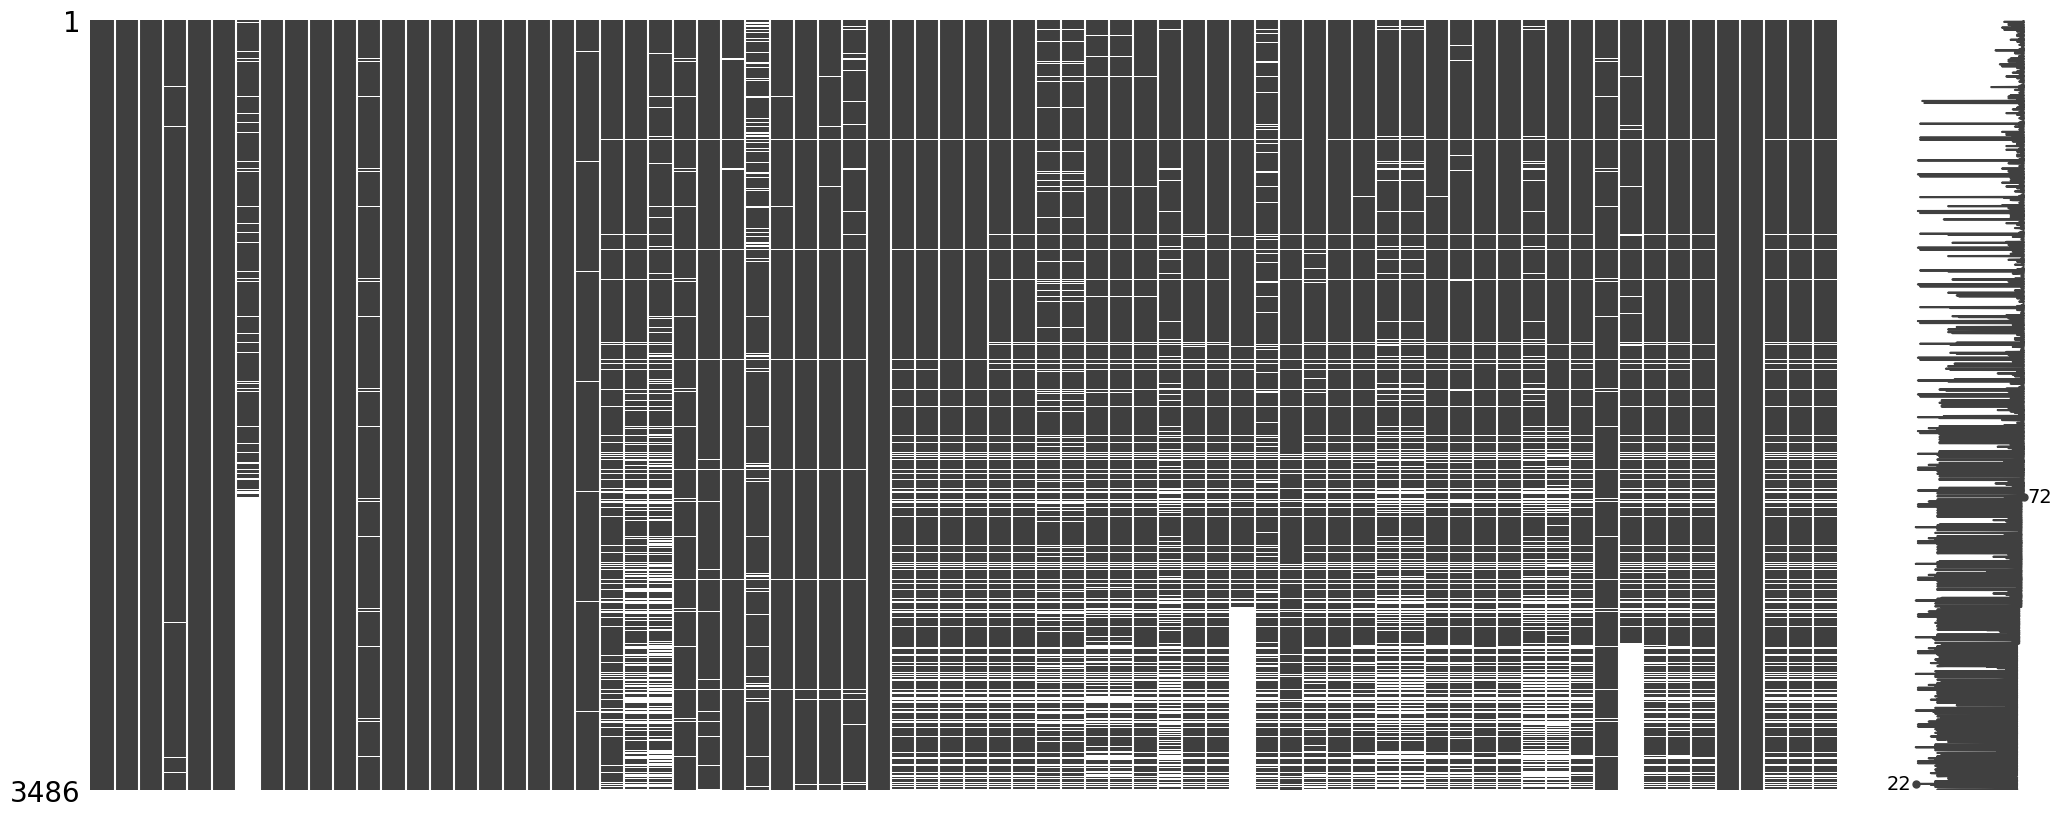

In [24]:
msno.matrix(df_result)

In [25]:
# Calculate the percentage of missing values for each column
missing_percent = df_result.isnull().mean() * 100

# Create a DataFrame to display the results
missing_percent_df = pd.DataFrame({'Column': missing_percent.index, 'Missing (%)': missing_percent.values})

# Sort the DataFrame by the percentage of missing values in descending order
missing_percent_df = missing_percent_df.sort_values(by='Missing (%)', ascending=False)

# Display the DataFrame
missing_percent_df.head(35)

,Column,Missing (%)
6,pf_ss_disappearances_organized,43.086632
47,ef_trade_movement_visit,28.829604
63,ef_regulation_business_licensing,26.907631
23,ef_government_tax_payroll_data,21.256454
59,ef_regulation_business_adm,20.510614
44,ef_trade_regulatory_nontariff,20.022949
53,ef_regulation_labor_firing,19.535284
54,ef_regulation_labor_bargain,19.506598
60,ef_regulation_business_burden,18.330465
22,ef_government_tax_income_data,16.351119


In [26]:
df_result.columns

Index(['year', 'countries', 'region', 'pf_ss_disappearances_disap',
       'pf_ss_disappearances_violent', 'pf_ss_disappearances_violent_data',
       'pf_ss_disappearances_organized', 'pf_ss_disappearances_fatalities',
       'pf_ss_disappearances_fatalities_data', 'pf_ss_disappearances_injuries',
       'pf_ss_disappearances_injuries_data', 'pf_ss_killings',
       'pf_ss_disappearances', 'pf_ss', 'pf_expression_direct_killed',
       'pf_expression_direct_killed_data', 'pf_expression_direct_jailed',
       'pf_expression_direct_jailed_data', 'pf_expression_direct',
       'pf_expression_cld', 'pf_identity_divorce', 'pf_identity_fgm',
       'ef_government_tax_income_data', 'ef_government_tax_payroll_data',
       'ef_government_soa', 'ef_government', 'ef_legal_protection',
       'ef_legal_military', 'ef_legal_integrity', 'ef_legal_enforcement',
       'ef_legal_regulatory', 'ef_legal_police', 'ef_gender', 'ef_money_sd',
       'ef_money_sd_data', 'ef_money_inflation', 'ef_money_inf

## Encoding categorical variables

In [27]:
# One-hot encode the 'countries' and 'region' columns
countries_dummies = pd.get_dummies(df_result['countries'], prefix='country')
region_dummies = pd.get_dummies(df_result['region'], prefix='region')

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df_result, countries_dummies, region_dummies], axis=1)

# Display the resulting DataFrame
print(df_encoded.head())

   year  countries                         region  pf_ss_disappearances_disap  \
0  2020    Albania                 Eastern Europe                        10.0   
1  2020    Algeria     Middle East & North Africa                        10.0   
2  2020     Angola             Sub-Saharan Africa                        10.0   
3  2020  Argentina  Latin America & the Caribbean                         5.0   
4  2020    Armenia        Caucasus & Central Asia                        10.0   

   pf_ss_disappearances_violent  pf_ss_disappearances_violent_data  \
0                     10.000000                                0.0   
1                      9.687083                               25.0   
2                      9.582498                               25.0   
3                     10.000000                                0.0   
4                     10.000000                                0.0   

   pf_ss_disappearances_organized  pf_ss_disappearances_fatalities  \
0                     